<div align="center">

# Алгоритмы отладки с использованием кривых обучения и валидации

</div>

---

## Диагностика моделей с помощью кривых обучения и валидации


#### Что такое кривая обучения?

* **Кривая обучения (learning curve)** — график точности (или ошибки) модели на обучающем и проверочном наборах в зависимости от размера обучающего набора.

#### Диагностика проблем: смещение и дисперсия

* **Высокое смещение (underfitting, недообучение):**

  * Низкая точность как на обучающем, так и на проверочном наборе.
  * Модель слишком простая, не улавливает закономерности данных.
  * Решения:

    * Увеличить сложность модели (больше параметров, более глубокие деревья и т.п.).
    * Добавить новые признаки (feature engineering).
    * Уменьшить регуляризацию (например, в SVM или логистической регрессии).

* **Высокая дисперсия (overfitting, переобучение):**

  * Большой разрыв между высокой точностью на обучении и низкой на проверочном наборе.
  * Модель слишком сложная и "запоминает" шум обучающих данных.
  * Решения:

    * Собрать больше обучающих данных (если возможно).
    * Уменьшить сложность модели.
    * Увеличить регуляризацию.
    * Отобрать или сократить количество признаков (feature selection).

#### Как использовать кривые обучения?

* Построить график точности на обучающем и валидационном наборах при разных объемах обучающих данных.
* **Анализ графика показывает**, страдает ли модель от смещения или дисперсии, и поможет понять, стоит ли собирать больше данных для улучшения качества.

#### Особенности и ограничения

* Добавление данных обычно помогает уменьшить переобучение, но если данные сильно зашумлены или модель уже оптимальна, это может не дать эффекта.
* Регуляризация и отбор признаков — эффективные инструменты для борьбы с переобучением.


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

In [18]:
# Загрузка набора данных из локального хранилища
df = pd.read_csv('~/Рабочий стол/ML/Data/wdbc.data',
                 header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


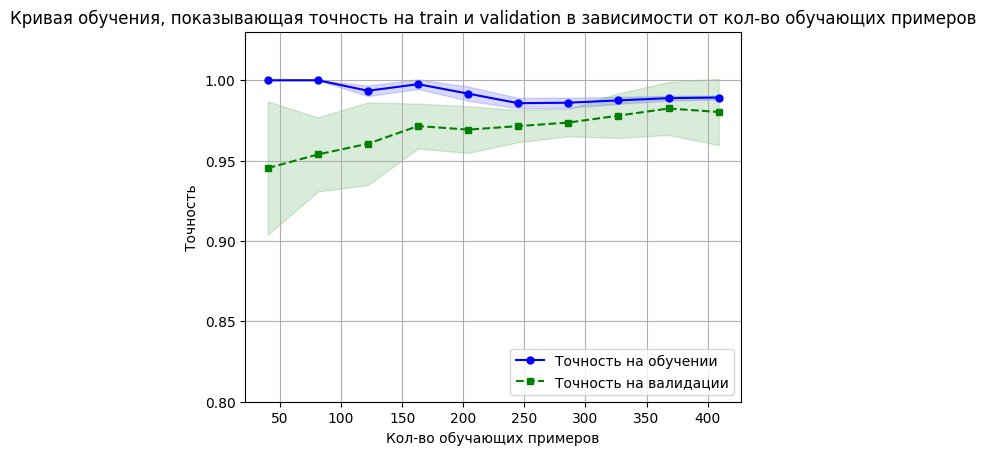

In [19]:
# Разделяем данные на
X = df.loc[:, 2:].values
y = df.loc[:, 1].values

# Преобразуем метки классов (диагнозы) в целые числа
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

# Проверка сопоставлений le
le.transform(['M', 'B'])

# Разделение на train и test
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size = 0.20,
                     stratify = y,
                     random_state = 1)

# Объединение всех этапов в конвейер
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty = 'l2',max_iter = 10000))

# Кривая обучения
train_sizes, train_scores, test_scores = \
                        learning_curve(estimator = pipe_lr,
                                       X = X_train,
                                       y = y_train,
                                       train_sizes = np.linspace(
                                           0.1, 1.0, 10),
                                       cv = 10,
                                       n_jobs = 1)

                        
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(train_sizes, train_mean,
         color = 'blue', marker = 'o',
         markersize = 5, label = 'Точность на обучении')
plt.fill_between(train_sizes, 
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15, color = 'blue')
plt.plot(train_sizes, test_mean,
         color = 'green', linestyle = '--',
         marker = 's', markersize = 5,
         label = 'Точность на валидации')
plt.fill_between(train_sizes, 
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color = 'green')
plt.grid()
plt.xlabel('Кол-во обучающих примеров')
plt.ylabel('Точность')
plt.title('Кривая обучения, показывающая точность на train и validation в зависимости от кол-во обучающих примеров')
plt.legend(loc = 'lower right')
plt.ylim([0.8, 1.03])
plt.show()


С помощью параметра `max_iter = 10000` в объекте `LogisticRegression`, который по умолчанию использует **1000 итераций**, мы увеличили этот параметр, чтобы избежать проблем сходимости при наборе данных меньшего размера или при экстремальных значениях параметров регуляризации.

С помощью параметра `train_sizes` в функции `learning_curve` мы можем задавать абсолютное или относительное кол-во экземпляров в обучающем наборе, мы установили `train_sizes = np.linspace(0.1, 1.0, 10)`, чтобы разбить набор данных на 10 равномерно распределенных интервалов. По умолчанию `learning_curve` использует стратифицированную k-кратную перекрестную проверку для расчета точности классификатора.

По этому графику можно сделать вывод, что наша модель достаточно хорошо работает
как с обучающими, так и с проверочными наборами данных, если для обучения применялось более 250 экземпляров. Мы также видим, что при использовании обучающих
наборов данных с менее чем 250 экземплярами точность обучения увеличивается, но и
разрыв между точностью на обучающем и проверочном наборе тоже растет - это показатель нарастающего переобучения.

---

## Кривые валидации (устраненения переобучения и недообучения)

* **Кривая валидации (validation curve)** — график зависимости производительности модели от значения гиперпараметра (например, степени регуляризации или сложности модели).

**Кривые валидации** связаны с **кривыми обучения**, но вместо того, чтобы строить кривые в зависимости от размера набора, мы варьируем значения параметрвов модели - например, обратный параметр регуляризации `C` в логистической регресии.



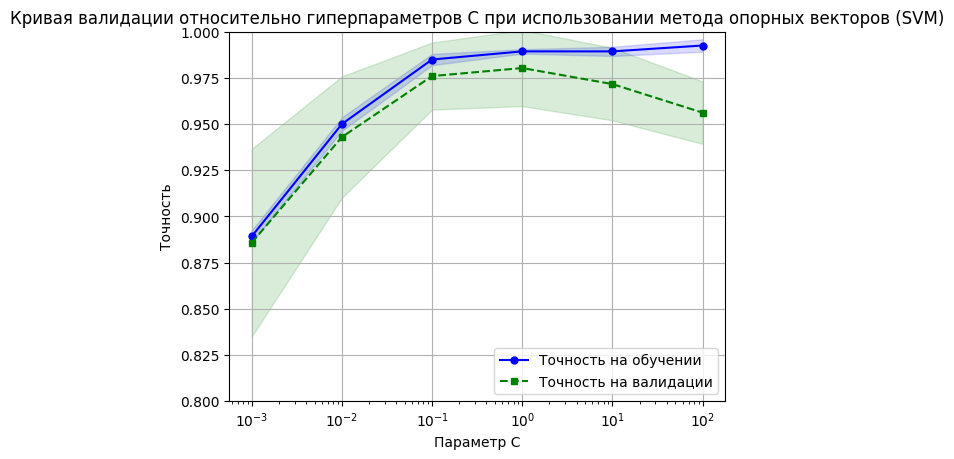

In [26]:
# Кривая валидации
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                            estimator = pipe_lr,
                            X = X_train,
                            y = y_train,
                            param_name = 'logisticregression__C',
                            param_range = param_range,
                            cv = 10)

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(param_range, train_mean,
         color = 'blue', marker = 'o',
         markersize = 5, label = 'Точность на обучении')
plt.fill_between(param_range, 
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15, color = 'blue')
plt.plot(param_range, test_mean,
         color = 'green', linestyle = '--',
         marker = 's', markersize = 5,
         label = 'Точность на валидации')
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color = 'green')
plt.grid()
plt.xscale('log')
plt.xlabel('Параметр C')
plt.ylabel('Точность')
plt.title('Кривая валидации относительно гиперпараметров C при использовании метода опорных векторов (SVM)')
plt.legend(loc = 'lower right')
plt.ylim([0.8, 1.0])
plt.show()



> На рисунке показана кривая валидации для параметра `C`. Функция `validation_curve` по умолчанию использует стратифицированную k-кратную перекрестную проверку для оценки производительности классификатора.
> При малых значениях `C` регуляризация сильная, поэтому модель недообучается (высокое смещение). При больших значениях `C` регуляризация слабая, и модель начинает переобучаться (высокая дисперсия).
> Оптимальный баланс между смещением и дисперсией наблюдается в области `C` от **0.1** до **1.0**.

